# Pneumonia Detection

## Download Data

In [2]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d wilhelmberghammer/chest-xrays-pneumonia-detection

## Extract Data

In [ ]:
!unzip '/content/chest-xrays-pneumonia-detection.zip' -d '/tmp'

In [8]:
import tensorflow as tf
import numpy as np
import shutil
import os

TRAIN_PATH = '/tmp/data/train'
VAL_PATH = '/tmp/data/val'
VAL_SIZE = 0.2

labels = ['BAC_PNEUMONIA', 'NORMAL', 'VIR_PNEUMONIA']
try:
  os.mkdir(VAL_PATH)
  for label in labels:
    os.mkdir(os.path.join(VAL_PATH, label))
except FileExistsError:
  pass

# move several train image file to val set
train_bac = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[0])+'/*.jpeg'))
train_normal = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[1])+'/*.jpeg'))
train_viral = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[2])+'/*.jpeg'))

rng = np.random.RandomState(42)
rng.shuffle(train_bac)
rng.shuffle(train_normal)
rng.shuffle(train_viral)

for i, train_files in enumerate([train_bac, train_normal, train_viral]): 
  val_split = int(len(train_files)*VAL_SIZE)
  train_files = train_files[:val_split]
  for train_file in train_files:
    file_path = os.path.join(VAL_PATH, labels[i])
    shutil.move(train_file, file_path)
  

In [9]:
print(len(os.listdir('/tmp/data/train/BAC_PNEUMONIA')))
print(len(os.listdir('/tmp/data/train/NORMAL')))
print(len(os.listdir('/tmp/data/train/VIR_PNEUMONIA')))
print()
print(len(os.listdir('/tmp/data/val/BAC_PNEUMONIA')))
print(len(os.listdir('/tmp/data/val/NORMAL')))
print(len(os.listdir('/tmp/data/val/VIR_PNEUMONIA')))
print()
print(len(os.listdir('/tmp/data/test/BAC_PNEUMONIA')))
print(len(os.listdir('/tmp/data/test/NORMAL')))
print(len(os.listdir('/tmp/data/test/VIR_PNEUMONIA')))

1108
1104
1108

276
276
276

100
100
100


## Data Visualization

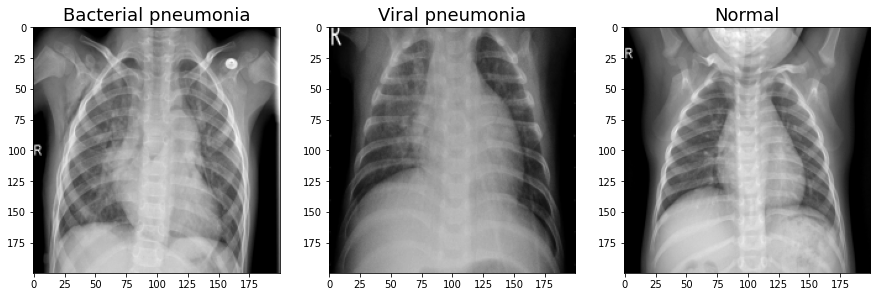

In [10]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from google.colab.patches import cv2_imshow


def show_image(img_path, titles):
  fig,ax = plt.subplots(1, 3, figsize=(15,15))
  dim = (200,200)
  for i, (img, title) in enumerate(zip(img_path, titles)):
    image = cv2.imread(img, 0)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    ax[i].imshow(resized, cmap=cm.gray)
    ax[i].set_title(title, fontdict={'fontsize':18})
    
imgs = ['', '', '']
imgs[0]= '/tmp/data/train/BAC_PNEUMONIA/person12_bacteria_48.jpeg'
imgs[1] = '/tmp/data/train/VIR_PNEUMONIA/person1004_virus_1686.jpeg'
imgs[2] = '/tmp/data/train/NORMAL/IM-0119-0001.jpeg' 

titles = ['Bacterial pneumonia', 'Viral pneumonia', 'Normal']

show_image(imgs, titles)

## Image Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generate_image():
  TRAINING_DIR = "/tmp/data/train/"
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      shear_range=.2,
      zoom_range=.2,
      height_shift_range=.2,
      width_shift_range=.2,
      fill_mode="nearest",
      horizontal_flip=True,
      vertical_flip=True,

  )

  train_generator = train_datagen.flow_from_directory(
      TRAINING_DIR,
      target_size=(224, 224),
      batch_size=32,
      class_mode="categorical",
      color_mode='grayscale',
  )

  VALIDATION_DIR = "/tmp/data/val/"
  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(
      VALIDATION_DIR,
      target_size=(224, 224),
      batch_size= 16,
      class_mode="categorical",
      color_mode='grayscale',
  )
  return train_generator, validation_generator

Found 3320 images belonging to 3 classes.
Found 828 images belonging to 3 classes.


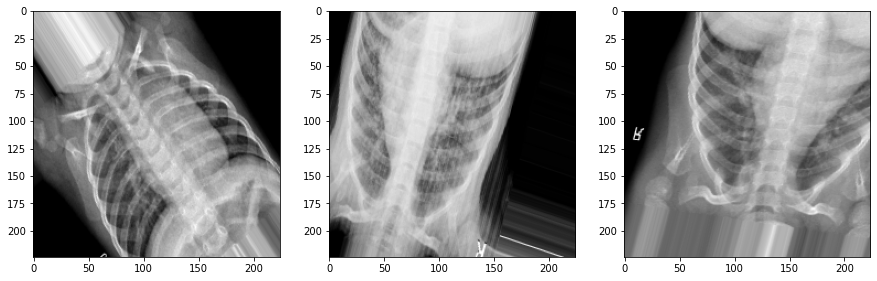

In [12]:
data_augmentationn = generate_image()[0]
x_batch, y_batch = next(iter(data_augmentationn))

def show_image_augmentation(batch, n=3):
  fig,ax = plt.subplots(1, n, figsize=(15,15))
  for i in range (0,n):
    image = batch[i]
    image = np.squeeze(image, axis=-1)
    ax[i].imshow(image, cmap=cm.gray)

show_image_augmentation(x_batch)



## Modeling with InceptionResNetV2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

conv_base = InceptionResNetV2(include_top=False, weights='imagenet',
                       input_shape=(224,224,3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block8_1_conv':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

model = Sequential()
model.add(layers.Conv2D(3, (3,3), padding='same',
                        input_shape=(224,224,1)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu',
                                kernel_regularizer=L2(0.1)))
model.add(layers.Dense(3, activation='softmax'))

optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
             metrics=[keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall'),
                        keras.metrics.AUC(name='auc'),
                        keras.metrics.CategoricalAccuracy(name='acc')])                                                     

219062272/219055592 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_203 (Conv2D)          (None, 224, 224, 3)       30        
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               9830656   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 64,168,193
Trainable params: 32,272,833
Non-trainable params: 31,895,360
_________________________________________________________________


## Training

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self,
               desired_acc=0.5):
    self.desired_acc = desired_acc

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>self.desired_acc):
      print(f"\nReached {self.desired_acc} accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

train_generator, validation_generator = generate_image()

callbacks = myCallback(0.86)
history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Found 3320 images belonging to 3 classes.
Found 828 images belonging to 3 classes.
Epoch 1/100
104/104 [==============================] - 111s 646ms/step - loss: 8.3303 - precision: 0.6721 - recall: 0.5729 - auc: 0.7945 - acc: 0.6386 - val_loss: 11.4132 - val_precision: 0.5614 - val_recall: 0.4746 - val_auc: 0.7203 - val_acc: 0.5314
Epoch 2/100
104/104 [==============================] - 61s 587ms/step - loss: 1.2191 - precision: 0.7507 - recall: 0.6494 - auc: 0.8717 - acc: 0.7142 - val_loss: 10.6707 - val_precision: 0.4503 - val_recall: 0.4263 - val_auc: 0.5782 - val_acc: 0.4481
Epoch 3/100
104/104 [==============================] - 61s 585ms/step - loss: 1.3443 - precision: 0.7548 - recall: 0.6732 - auc: 0.8729 - acc: 0.7235 - val_loss: 3.0625 - val_precision: 0.4920 - val_recall: 0.4457 - val_auc: 0.6363 - val_acc: 0.4867
Epoch 4/100
104/104 [==============================] - 61s 583ms/step - loss: 1.0052 - precision: 0.7808 - recall: 0.7060 - auc: 0.8981 - acc: 0.7509 - val_loss: 0.

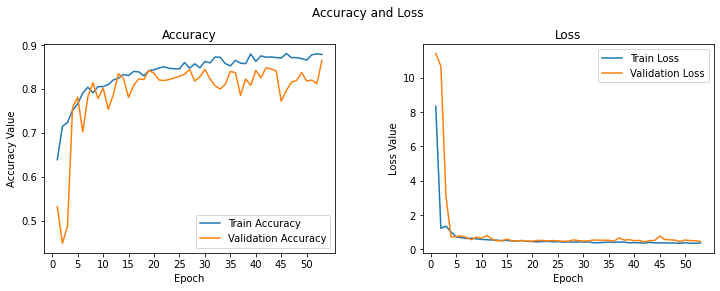

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Accuracy and Loss', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = 53
epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
 
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Load Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/IESC/inceptionresnet_pneumonia_model.zip', 'r') as zip_ref:
    zip_ref.extractall('/')

In [14]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/model')

## Plot Confusion Matrix

In [15]:
TEST_DIR = "/tmp/data/test/"
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size= 1,
    class_mode="categorical",
    color_mode='grayscale',
    shuffle = False,
)

Found 300 images belonging to 3 classes.


In [16]:
import numpy as np

filenames = test_generator.filenames
nb_samples = len(filenames)

predictions = model.predict(test_generator, steps = nb_samples)
y_pred = np.rint(predictions)
y_pred = tf.argmax(y_pred, axis=1)

y_true = test_generator.classes

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=60)
    plt.yticks(tick_marks, classes, fontsize=60)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=60)

    plt.ylabel('True label', fontsize=60)
    plt.xlabel('Predicted label', fontsize=60)

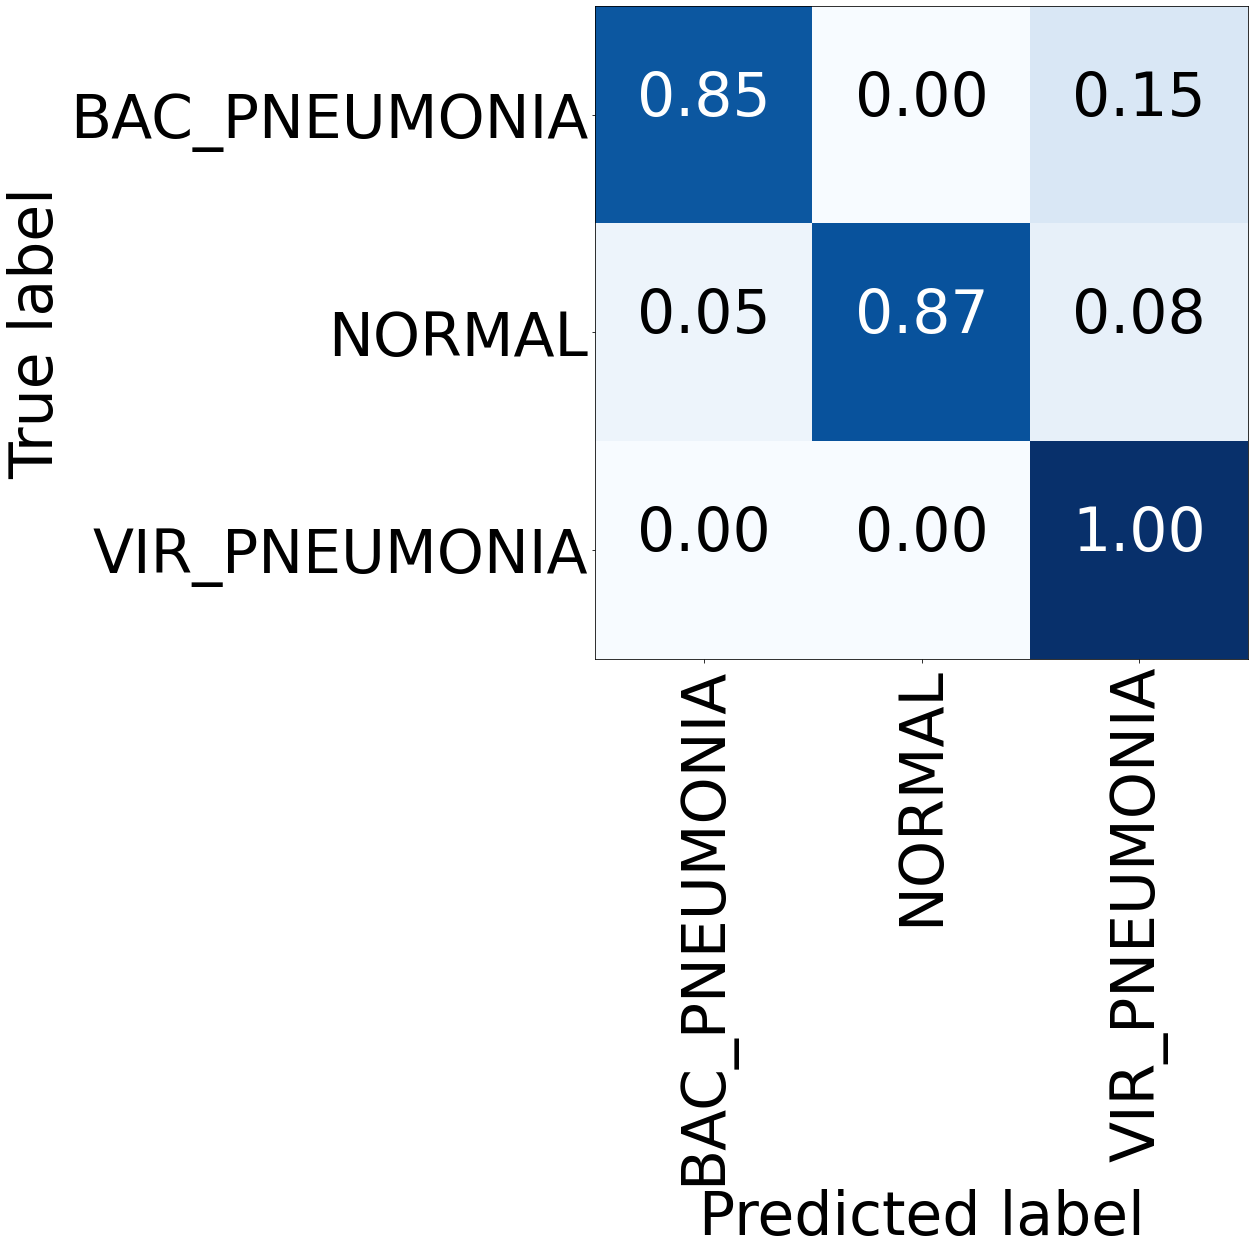

In [18]:
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=test_generator.class_indices.keys(), title="Confusion matrix")
plt.show()

In [20]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.85      0.89       100
           1       1.00      0.87      0.93       100
           2       0.81      1.00      0.90       100

    accuracy                           0.91       300
   macro avg       0.92      0.91      0.91       300
weighted avg       0.92      0.91      0.91       300



In [21]:
model.evaluate(test_generator)

300/300 [==============================] - 73s 231ms/step - loss: 0.2931 - precision: 0.9220 - recall: 0.9067 - auc: 0.9838 - acc: 0.9233


[0.2930707037448883,
 0.9220339059829712,
 0.9066666960716248,
 0.9838444590568542,
 0.9233333468437195]

## Save Model

In [ ]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [ ]:
!zip -r /content/inceptionresnet_pneumonia_model.zip /content/model/

  adding: content/model/ (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/model/variables/variables.index (deflated 79%)
  adding: content/model/saved_model.pb (deflated 93%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/keras_metadata.pb (deflated 96%)


In [ ]:
from google.colab import files

files.download("/content/inceptionresnet_pneumonia_model.zip")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp inceptionresnet_pneumonia_model.zip '/content/gdrive/My Drive'


ls: cannot access '/content/gdrive/My Drive/downloads/': No such file or directory


In [ ]:
!ls -lt '/content/gdrive/My Drive/' 